In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import warnings
# warnings.filterwarnings('always')

fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [2]:
print("Fake News Dataset Shape:", fake.shape)
print("True News Dataset Shape:", true.shape)

Fake News Dataset Shape: (23481, 4)
True News Dataset Shape: (21417, 4)


In [3]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
true.head()


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
# Concat two data frames together 

fake["label"] = 0  # 0 = Fake
true["label"] = 1  # 1 = Real

df = pd.concat([fake, true], axis=0)

In [6]:
print(df.isnull().sum())

title      0
text       0
subject    0
date       0
label      0
dtype: int64


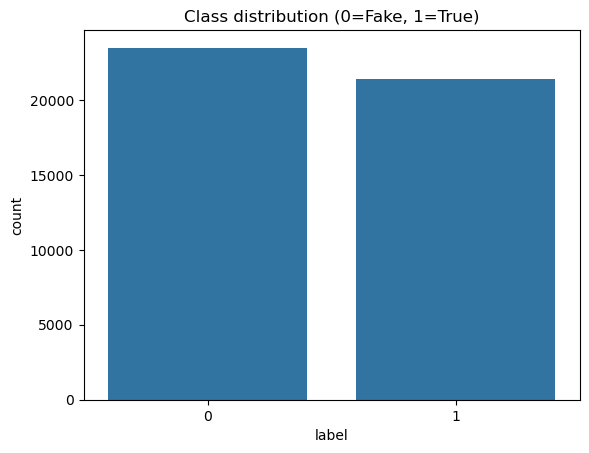

In [7]:
sns.countplot(x="label", data=df)
plt.title("Class distribution (0=Fake, 1=True)")
plt.show()

In [8]:
# add dependency
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

In [9]:
# uppercase to lowercase
df["text"] = df["text"].str.lower()

# deleting link and stuff XD
df["text"] = df["text"].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x))  
df["text"] = df["text"].apply(lambda x: re.sub(r'\d+', '', x))  
df["text"] = df["text"].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [10]:
# delete stopwords
stop_words = set(stopwords.words('english'))
df["text"] = df["text"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [11]:
# Lemmatization
lemmatizer = WordNetLemmatizer()
df["text"] = df["text"].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

In [12]:
df["text"].head()

0    donald trump wish american happy new year leav...
1    house intelligence committee chairman devin nu...
2    friday revealed former milwaukee sheriff david...
3    christmas day donald trump announced would bac...
4    pope francis used annual christmas day message...
Name: text, dtype: object

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
# import warnings
# warnings.filterwarnings("ignore")

# We have to input 'text' as the only input to the models --> prevent data leakage 
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

vectorizer = TfidfVectorizer(max_df=0.7)
tfidf_train = vectorizer.fit_transform(X_train)
tfidf_test = vectorizer.transform(X_test)

models = {
    "Logistic Regression": LogisticRegression(max_iter=250),
    "Linear SVC": LinearSVC(),
    "Multinomial NB": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=40),
    "Gradient Boosting": GradientBoostingClassifier(random_state=40)
}

results = []

for name, model in models.items():
    model.fit(tfidf_train, y_train)
    y_pred = model.predict(tfidf_test)
    acc = accuracy_score(y_test, y_pred)
    results.append({"Model": name, "Accuracy": acc})
    print(f"{name}:", classification_report(y_test, y_pred))

results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print("Model Comparison:")
print(results_df)

Logistic Regression:               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



D:\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Linear SVC:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4696
           1       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

Multinomial NB:               precision    recall  f1-score   support

           0       0.97      0.94      0.95      4696
           1       0.93      0.97      0.95      4284

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980

Random Forest:               precision    recall  f1-score   support

           0       1.00      0.99      0.99      4696
           1       0.99      1.00      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.

In [14]:
from collections import Counter

fake_words = Counter(" ".join(df[df["label"]==0]["text"]).split())
real_words = Counter(" ".join(df[df["label"]==1]["text"]).split())

exclusive_fake = set(fake_words) - set(real_words)
exclusive_real = set(real_words) - set(fake_words)

print("Fake sample words:", list(exclusive_fake)[:20])
print("Real sample words :", list(exclusive_real)[:20])

Fake sample words: ['talkingvia', 'youtubemair', 'statesacorn', 'africaat', 'greatif', 'followinglike', 'householdswhat', 'lorenzen', 'hannitytoensing', 'boldnessbeing', 'brashness', 'leaderyou', 'underarm', 'abilityall', 'savedfeatured', 'officethankfully', 'supportersand', 'foodprocessing', 'successorspresident', 'treatedcarter']
Real sample words : ['nettle', 'antimacri', 'mmamaloko', 'scaledback', 'petrolbomb', 'saintremydeprovence', 'radogno', 'wpoliticepl', 'undertrials', 'nlnfvk', 'lopez’', 'brexiteers', 'pacify', '“quiet”', 'amsterdamunited', '“gunpocalypse”', 'boao', '“racist”', 'direct”', 'doing’”']


In [15]:
duplicates = df.duplicated(subset=["text"], keep=False)
print(" dup news :", duplicates.sum())

 dup news : 11426


In [16]:
#delete duplicated
df_clean = df.drop_duplicates(subset=["text"]).reset_index(drop=True)
print(f": {len(df_clean)}")

: 38583


In [17]:
# preprocessing agian
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)               
    text = re.sub(r"\d+", "", text)                  
    text = text.translate(str.maketrans("", "", string.punctuation)) 
    text = re.sub(r"\s+", " ", text).strip()
    return text

df_clean["clean_text"] = df_clean["text"].apply(clean_text)

In [18]:
# Identify exclusive words

fake_words = Counter(" ".join(df_clean[df_clean["label"]==0]["clean_text"]).split())
real_words = Counter(" ".join(df_clean[df_clean["label"]==1]["clean_text"]).split())

exclusive_fake = set(fake_words) - set(real_words)
exclusive_real = set(real_words) - set(fake_words)

In [19]:
# delete exclusive

def remove_exclusive_and_rare_words(text, rare_threshold=2):
    words = text.split()
    words = [w for w in words if w not in exclusive_fake and w not in exclusive_real]
    counts = Counter(words)
    words = [w for w in words if counts[w] >= rare_threshold]
    return " ".join(words)

df_clean["clean_text"] = df_clean["clean_text"].apply(remove_exclusive_and_rare_words)

In [20]:
# train-test and vectorize
X_train, X_test, y_train, y_test = train_test_split(
    df_clean["clean_text"], df_clean["label"], test_size=0.2,
    random_state=42, stratify=df_clean["label"]
)

vectorizer = TfidfVectorizer(max_df=0.7, min_df=3, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [21]:

models = {
    "Linear SVC": LinearSVC(max_iter=3000),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=250, random_state=40, n_jobs=-1),
    "Multinomial NB": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=250)
}

results = {}
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    preds = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, preds)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds))

print("Summary of accuracies:")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

D:\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Linear SVC Accuracy: 0.9492
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      3479
           1       0.96      0.95      0.95      4238

    accuracy                           0.95      7717
   macro avg       0.95      0.95      0.95      7717
weighted avg       0.95      0.95      0.95      7717

Gradient Boosting Accuracy: 0.8878
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      3479
           1       0.91      0.88      0.90      4238

    accuracy                           0.89      7717
   macro avg       0.89      0.89      0.89      7717
weighted avg       0.89      0.89      0.89      7717

Random Forest Accuracy: 0.9375
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      3479
           1       0.93      0.95      0.94      4238

    accuracy                           0.94      7717
   macro avg       0.94      0.94 

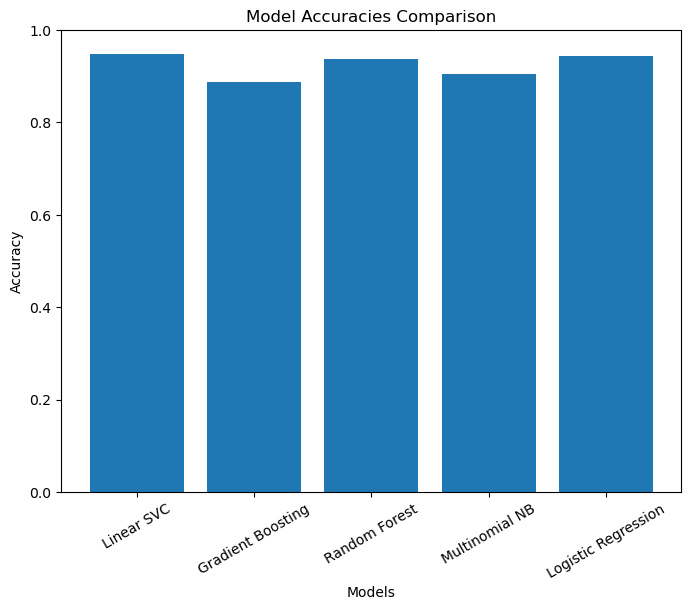

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(results.keys(), results.values())
plt.title("Model Accuracies Comparison")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.xticks(rotation=30)
plt.ylim(0, 1)  
plt.show()


In [24]:
import joblib

best_model = LinearSVC(max_iter=3000)
best_model.fit(X_train_tfidf, y_train)

# Save the model
joblib.dump(best_model, "final_model.pkl")

# Save the TF-IDF vectorizer as well (important for transforming new text)
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

print("Model and vectorizer saved successfully!")


D:\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Model and vectorizer saved successfully!


In [25]:
import joblib

model = joblib.load("final_model.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

# Example usage
new_texts = ["Breaking news: The government announces a new policy", 
             "Aliens landed in New York! Fake news spreading fast"]

X_new = vectorizer.transform(new_texts)

predictions = model.predict(X_new)
print(predictions)   

[0 0]
